In [83]:
import numpy as np
import matplotlib.pyplot as plt
import os
path = os.path.abspath(os.path.join(os.getcwd(),".."))
print(path)
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from dynamics_networks import DynamicsNetwork, DynamicsParamsOptimizer, EncoderDynamicsNetwork, EncoderDecoderDynamicsNetwork, VAEDynamicsNetwork
from rl.policy_networks import DPG_PolicyNetwork
from utils.load_params import load_params
from utils.common_func import rand_params
from defaults import DYNAMICS_PARAMS, HYPER_PARAMS
from environment import envs
import torch

/home/zihan/Research/PKU/sim2rel_system_id


In [84]:
env_name = 'inverteddoublependulum'
data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'
param_dim = len(DYNAMICS_PARAMS[env_name+'dynamics'])
print('parameter dimension: ', param_dim)

parameter dimension:  5


In [85]:
test_data = np.load(data_path, allow_pickle=True)
print('number of samples in dest data: ', len(test_data))
idx=5  # index of sample to test: 0-10
sa = test_data[idx]['sa']
s_ = test_data[idx]['s_']
params = test_data[idx]['params'] # true parameters
sa = torch.Tensor(sa)
s_ = torch.Tensor(s_)
print(sa.shape, s_.shape)
print('true parameters: ', params)

number of samples in dest data:  10
torch.Size([8397, 12]) torch.Size([8397, 11])
true parameters:  [0.04490007 9.947507   0.4617513  0.6338595  1.1446342 ]


## 1. Direct optimization through NN

In [86]:
def train_params(Env, embedding, epoch=1000, lr=1e-2, dynamics_model_path='./', env_settings={}, default_params={}, data_path='./'):
    """
    Train the dynamics parameters with a trained/fixed dynamics prediction model, using the real-world dataset.
    Model input: state, action, dynamics parameters (learnable).
    Model output: next state.
    """
    env = Env(**env_settings, **default_params)
    if embedding:
        param_dim = HYPER_PARAMS[Env.name+'dynamics']['latent_dim']
        param_ini_v = np.zeros(param_dim)
        model = DynamicsParamsOptimizer(env.observation_space, env.action_space, param_dim, param_ini_v, num_hidden_layers=6, lr=lr)
    else:
        param_dim = len(DYNAMICS_PARAMS[Env.name+'dynamics'])
        param_ini_v = [np.mean(v) for k, v in env.parameters_spec.items() if k in DYNAMICS_PARAMS[Env.name+'dynamics']]
        model = DynamicsParamsOptimizer(env.observation_space, env.action_space, param_dim, param_ini_v, num_hidden_layers=6, lr=lr)
    model.dynamics_model.load_state_dict(torch.load(dynamics_model_path))
    model.dynamics_model.eval()

#     sa = np.load(data_path+'/sa.npy')
#     s_ = np.load(data_path+'/s_.npy')

    for ep in range(epoch):
        s_pred = model.forward(sa)
        model.optimizer.zero_grad()
        loss = model.criterion(s_pred, s_)
        loss.backward()
        model.optimizer.step()
        if ep%100==0:
            print('epoch: {}, loss: {}'.format(ep, loss.item()))
        
    return model.params

In [87]:
Env = envs[env_name]  # pandapushik2dsimple', 'inverteddoublependulum'
Type = ['EncoderDynamicsNetwork', 'EncoderDecoderDynamicsNetwork', 'VAEDynamicsNetwork'][2]

alpha = train_params(Env, embedding=True, \
              dynamics_model_path=path+'/data/dynamics_data/{}/model/{}_dim{}/dynamics'.format(env_name, Type, str(param_dim)), \
                   lr=1e-3,   epoch=100, data_path=data_path)
print('Method 1: predicted encoded parameters: ', alpha)

epoch: 0, loss: 0.03791588544845581
Method 1: predicted encoded parameters:  tensor([-0.1058, -0.0864], requires_grad=True)


In [88]:
from dynamics_predict.dynamics_networks import DynamicsEncoder, DynamicsVariationalEncoder

# load encoder
if Type in ['EncoderDynamicsNetwork', 'EncoderDecoderDynamicsNetwork']:  # normal encoder
    encoder = DynamicsEncoder(param_dim=len(DYNAMICS_PARAMS[env_name]), latent_dim=HYPER_PARAMS[env_name+'dynamics']['latent_dim'])  # latent dimension needs to align with the trained DynamicsEncoder 
elif Type == 'VAEDynamicsNetwork': # variational auto-encoder
    encoder = DynamicsVariationalEncoder(param_dim=len(DYNAMICS_PARAMS[env_name+'dynamics']), latent_dim=HYPER_PARAMS[env_name+'dynamics']['latent_dim'])  # 
encoder.load_state_dict(torch.load(path+'/data/dynamics_data/{}/model/{}_dim{}/encoder'.format(env_name, Type, str(len(DYNAMICS_PARAMS[env_name+'dynamics'])))))
encoder.eval()

# normalize the data
[norm_mean, norm_std] = np.load(path+'/data/dynamics_data/{}/norm_factor.npy'.format(env_name))
print('norm factors: ', norm_mean, norm_std)
params_ = (params - norm_mean)/norm_std
params_ = torch.FloatTensor([params_])
# print(params.shape)
mu, logvar = encoder(params_)
true_alpha = mu.detach().cpu().numpy()[0]
print('true encoded parameters: ', true_alpha)

norm factors:  [0.16154307 9.740149   0.6109008  0.60664666 1.0140377 ] [0.08051212 0.720381   0.17322679 0.17211911 0.28749457]
true encoded parameters:  [-0.07733309  2.479628  ]


## Bayesian optimization

In [188]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from environment import envs
from dynamics_predict.defaults import DYNAMICS_PARAMS, HYPER_PARAMS
from bayes_opt import BayesianOptimization
from dynamics_predict.dynamics_networks import DynamicsNetwork


class EmbeddingBayesianOptimization():
    def __init__(self, Env_name, data_path, dynamics_model_path):
        self.x=sa
        self.y=s_
#         self.x = tocrch.Tensor(np.load(data_path+'sa.npy'))
#         self.y = torh.Tensor(np.load(data_path+'s_.npy'))
        env = envs[Env_name]()
        self.env_name = Env_name
        self.dynamics_model = DynamicsNetwork(state_space=env.observation_space, action_space=env.action_space, \
                                              num_hidden_layers=6, param_dim=HYPER_PARAMS[self.env_name+'dynamics']['latent_dim'])
        self.dynamics_model.load_state_dict(torch.load(dynamics_model_path))

    def get_params_bound(self,):
        v_limit = 10.
        bounds = {'alpha_{}'.format(i): [-v_limit, v_limit] for i in range(HYPER_PARAMS[self.env_name+'dynamics']['latent_dim'])}
        return bounds
    
    def black_box_function(self, **alpha):
        """Function with unknown internals we wish to maximize.
        This is just serving as an example, for all intents and
        purposes think of the internals of this function, i.e.: the process
        which generates its output values, as unknown.
        """
        x=torch.cat((self.x, torch.Tensor(list(alpha.values())).repeat(self.x.shape[0],1)),axis=-1)
        y_=self.dynamics_model(x).detach().cpu().numpy()

        loss = np.square(np.subtract(self.y, y_)).mean()

        return -loss  # BO gives the maximum, so negagive loss


    def optimize(self, random_init=20, n_iter=500, result_path='params_bo.npy'):
        params_bound = self.get_params_bound()

        optimizer = BayesianOptimization(
            f=self.black_box_function,
            pbounds=params_bound,  # Here it defines the parameters to be randomized, which should also match with input arguments of black_box_function()
            verbose=2,  # verbose =2 print each iteration, verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=1,
        )
        
#         optimizer.probe(  # probe a certain datapoint at the beginning
#         params={"alpha_0": -1.0045, "alpha_1": 0.3682}, lazy=True)

        optimizer.maximize(
            init_points=random_init,
            n_iter=n_iter,
        )

        print(optimizer.max['params'])
        optimized_params = optimizer.max['params']
        np.save(result_path, [params_bound, optimized_params])
        return optimizer.res


In [189]:
dynamics_model_path = path+'/data/dynamics_data/{}/model/{}_dim{}/dynamics'.format(env_name, Type, str(param_dim))

data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'

ebo = EmbeddingBayesianOptimization(env_name, data_path, dynamics_model_path)
optimization_records = ebo.optimize()
np.save('../data/imgs/{}/bo{}_data.npy'.format(env_name, idx), optimization_records)

|   iter    |  target   |  alpha_0  |  alpha_1  |
-------------------------------------------------
|  1        | -0.2193   | -1.66     |  4.406    |
|  2        | -11.52    | -9.998    | -3.953    |
|  3        | -8.902    | -7.065    | -8.153    |
|  4        | -3.424    | -6.275    | -3.089    |
|  5        | -0.0462   | -2.065    |  0.7763   |
|  6        | -0.1161   | -1.616    |  3.704    |
|  7        | -2.504    | -5.911    |  7.562    |
|  8        | -7.589    | -9.452    |  3.409    |
|  9        | -0.03134  | -1.654    |  1.174    |
|  10       | -6.472    | -7.192    | -6.038    |
|  11       | -2.353    |  6.015    |  9.365    |
|  12       | -0.4543   | -3.732    |  3.846    |
|  13       | -1.829    |  7.528    |  7.892    |
|  14       | -13.36    | -8.299    | -9.219    |
|  15       | -3.327    | -6.603    |  7.563    |
|  16       | -6.389    | -8.033    | -1.578    |
|  17       | -1.505    |  9.158    |  0.6633   |
|  18       | -0.384    |  3.838    | -3.69     |


|  100      | -0.02442  | -0.7094   |  2.029    |
|  101      | -0.0245   | -0.6473   |  2.238    |
|  102      | -0.0241   | -0.2836   |  2.266    |
|  103      | -0.02458  |  0.1317   |  2.318    |
|  104      | -0.0245   | -0.9778   |  1.755    |
|  105      | -0.02428  |  0.01833  |  2.439    |
|  106      | -0.0254   | -0.4944   |  1.863    |
|  107      | -0.02519  | -0.3522   |  2.527    |
|  108      | -0.02406  | -0.4227   |  2.206    |
|  109      | -0.02457  | -0.8514   |  1.894    |
|  110      | -0.02557  | -1.255    |  1.518    |
|  111      | -0.02442  |  0.03665  |  2.262    |
|  112      | -0.02416  | -0.3821   |  2.184    |
|  113      | -0.02432  | -0.6347   |  2.156    |
|  114      | -0.02561  |  0.3301   |  2.29     |
|  115      | -0.02461  | -1.092    |  1.815    |
|  116      | -0.02403  | -0.1044   |  2.321    |
|  117      | -0.02455  | -0.8219   |  2.019    |
|  118      | -0.02406  | -0.241    |  2.306    |
|  119      | -0.02413  | -0.01475  |  2.406    |


|  200      | -0.02404  | -0.07142  |  2.342    |
|  201      | -0.02415  | -0.1029   |  2.447    |
|  202      | -0.02488  | -0.6136   |  2.344    |
|  203      | -0.02412  | -0.5269   |  2.202    |
|  204      | -0.02459  | -0.9755   |  1.904    |
|  205      | -0.02424  | -0.5553   |  2.076    |
|  206      | -0.02403  | -0.1614   |  2.379    |
|  207      | -0.02406  | -0.1344   |  2.298    |
|  208      | -0.0245   |  0.07694  |  2.272    |
|  209      | -0.02426  | -0.1511   |  2.228    |
|  210      | -0.02406  | -0.3843   |  2.237    |
|  211      | -0.0246   | -0.9972   |  1.661    |
|  212      | -0.02409  | -0.02852  |  2.385    |
|  213      | -0.02437  | -2.867e-0 |  2.477    |
|  214      | -0.02403  | -0.4171   |  2.245    |
|  215      | -0.02422  | -0.3214   |  2.387    |
|  216      | -0.02415  | -0.2428   |  2.394    |
|  217      | -0.02507  | -1.222    |  1.776    |
|  218      | -0.02404  | -0.3889   |  2.262    |
|  219      | -0.02435  | -0.2907   |  2.175    |


|  300      | -0.02445  | -0.6001   |  2.268    |
|  301      | -0.02462  | -0.8355   |  1.835    |
|  302      | -0.02448  | -0.373    |  2.103    |
|  303      | -0.02412  | -0.3993   |  2.329    |
|  304      | -0.02415  | -0.01199  |  2.321    |
|  305      | -0.02468  | -1.094    |  1.859    |
|  306      | -0.02407  | -0.34     |  2.314    |
|  307      | -0.02416  | -0.1114   |  2.262    |
|  308      | -0.02408  | -0.3776   |  2.316    |
|  309      | -0.02403  | -0.189    |  2.315    |
|  310      | -0.02406  | -0.1231   |  2.41     |
|  311      | -0.02417  | -0.2668   |  2.388    |
|  312      | -0.02415  | -0.3933   |  2.179    |
|  313      | -0.02479  | -0.8547   |  1.69     |
|  314      | -0.02402  | -0.07482  |  2.37     |
|  315      | -0.02441  | -0.7024   |  2.102    |
|  316      | -0.02404  | -0.4496   |  2.208    |
|  317      | -0.02414  | -0.4126   |  2.171    |
|  318      | -0.02406  | -0.1474   |  2.401    |
|  319      | -0.02406  | -0.3369   |  2.283    |


|  400      | -0.02997  | -1.335    |  0.3683   |
|  401      | -0.024    | -0.1232   |  2.357    |
|  402      | -0.02409  | -0.03814  |  2.328    |
|  403      | -0.02405  | -0.2291   |  2.326    |
|  404      | -0.02415  | -0.146    |  2.26     |
|  405      | -0.02405  | -0.3882   |  2.296    |
|  406      | -0.02427  | -0.5759   |  2.07     |
|  407      | -0.02405  | -0.4448   |  2.261    |
|  408      | -0.02401  | -0.1276   |  2.365    |
|  409      | -0.02414  | -0.1756   |  2.426    |
|  410      | -0.02697  |  0.4578   |  2.188    |
|  411      | -0.02415  | -0.2786   |  2.237    |
|  412      | -0.02409  | -0.4634   |  2.277    |
|  413      | -0.02443  | -0.4934   |  2.036    |
|  414      | -0.02411  | -0.4777   |  2.271    |
|  415      | -0.02412  | -0.5346   |  2.167    |
|  416      | -0.02414  | -0.2476   |  2.385    |
|  417      | -0.02441  |  0.04678  |  2.274    |
|  418      | -0.02414  | -0.2279   |  2.398    |
|  419      | -0.02401  | -0.09562  |  2.371    |


|  500      | -0.02408  | -0.2994   |  2.271    |
|  501      | -0.02404  | -0.1364   |  2.308    |
|  502      | -0.02416  | -0.2847   |  2.378    |
|  503      | -0.02406  | -0.1541   |  2.4      |
|  504      | -0.02429  | -0.5592   |  2.257    |
|  505      | -0.02708  | -1.198    |  2.218    |
|  506      | -0.0242   | -0.3773   |  2.174    |
|  507      | -0.02456  | -1.012    |  1.675    |
|  508      | -0.02415  | -0.5452   |  2.197    |
|  509      | -0.02411  | -0.1034   |  2.281    |
|  510      | -0.02411  | -0.2436   |  2.375    |
|  511      | -0.02416  |  0.01165  |  2.381    |
|  512      | -0.02406  | -0.3164   |  2.295    |
|  513      | -0.02414  | -0.1446   |  2.261    |
|  514      | -0.02426  | -0.03011  |  2.462    |
|  515      | -0.02407  | -0.2989   |  2.297    |
|  516      | -0.02417  | -0.4507   |  2.32     |
|  517      | -0.02437  | -0.107    |  2.209    |
|  518      | -0.0242   | -0.4431   |  2.334    |
|  519      | -0.02409  | -0.02864  |  2.386    |


-0.12318913003650778 2.3571828577789944


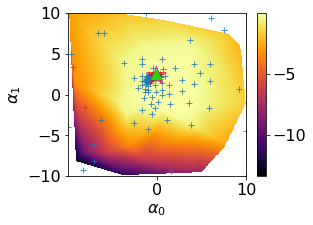

In [90]:
from matplotlib.colors import LogNorm
from matplotlib import cm
import scipy.interpolate
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# idx=5
font = {
#         'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 16}
optimization_records = np.load('../data/imgs/{}/bo{}_data.npy'.format(env_name, idx), allow_pickle=True)
matplotlib.rc('font', **font)

z=[]
x=[]
y=[]
alpha_id = [0,1]
for i, res in enumerate(optimization_records):
#     print("Iteration {}: \n\t{}".format(i, res))
    z.append(res['target'])
    x.append(res['params']['alpha_{}'.format(str(alpha_id[0]))])
    y.append(res['params']['alpha_{}'.format(str(alpha_id[1]))])

x=np.array(x)
y=np.array(y)
z=np.array(z)

# the optimal point found by BO
x_bo = x[np.argmax(z)]
y_bo = y[np.argmax(z)]

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
grid_x, grid_y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
values = scipy.interpolate.griddata((x, y), z, (grid_x, grid_y), method='linear')
plt.figure(figsize=(4,3))
plt.imshow(values, origin='lower', extent=[xmin, xmax, ymin, ymax],
          aspect='auto', cmap='inferno')
plt.plot(x,y, '+', alpha=0.8)
plt.xlabel(r'$\alpha_{}$'.format(str(alpha_id[0])))
plt.ylabel(r'$\alpha_{}$'.format(str(alpha_id[1])))
plt.colorbar()
print(x_bo, y_bo)
plt.scatter(x_bo, y_bo, s=600, marker="*", c='white')
# plt.scatter(*true_alpha, s=300, marker=".", c='red', alpha=0.8)
plt.plot(x_bo, y_bo, "*", c='red', markersize=20, alpha=0.6)

plt.plot(*true_alpha[alpha_id], '^', c='lime', markersize=10, alpha=0.8)

plt.savefig('../data/imgs/{}/bo{}.pdf'.format(env_name, idx), bbox_inches='tight')
plt.show()


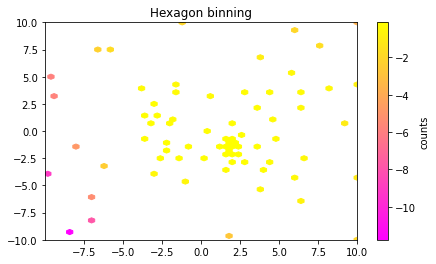

In [117]:
from matplotlib.colors import LogNorm
from matplotlib import cm

z=[]
x=[]
y=[]
for i, res in enumerate(optimization_records):
#     print("Iteration {}: \n\t{}".format(i, res))
    z.append(res['target'])
    x.append(res['params']['alpha_0'])
    y.append(res['params']['alpha_1'])
# x = y = np.linspace(-10, 10, 300)
# X, Y = np.meshgrid(x, y)
# x = X.ravel()
# y = Y.ravel()
x=np.array(x)
y=np.array(y)
z=np.array(z)
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
fig, axs = plt.subplots(ncols=1, sharey=True, figsize=(7, 4))
# fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs # ax = axs[k]
hb = ax.hexbin(x, y, C=z, gridsize=50, cmap='spring', bins=None)  # 'inferno'
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
# plt.colorbar()
plt.show()

In [92]:
np.pi/4

0.7853981633974483